In [1]:
import matplotlib.pyplot as plt
import os
import torch 
from torch.utils.data import DataLoader
import json
import sys
import torch

sys.path.append("src")
os.chdir('/home/george-vengrovski/Documents/projects/tweety_bert_paper')

from utils import load_model

weights_path = "/home/george-vengrovski/Documents/projects/tweety_bert_paper/experiments/TweetyBERT-MSE_LLB3_10_Mask/saved_weights/model_step_15800.pth"
config_path = "/home/george-vengrovski/Documents/projects/tweety_bert_paper/experiments/TweetyBERT-MSE_LLB3_10_Mask/config.json"

tweety_bert_model = load_model(config_path, weights_path)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


## Data Class

In [33]:
from torch.utils.data import DataLoader
from data_class import SongDetectorDataClass, CollateFunctionSongDetection

train_dir = "/home/george-vengrovski/Documents/data/finetune_labeled_data_train"
test_dir = "/home/george-vengrovski/Documents/data/finetune_labeled_data_test"

train_dataset = SongDetectorDataClass(train_dir, num_classes=2, psuedo_labels_generated=False)
test_dataset = SongDetectorDataClass(test_dir, num_classes=2, psuedo_labels_generated=False)

collate_fn = CollateFunctionSongDetection(segment_length=1000)  # Adjust the segment length if needed

train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=2, shuffle=True, collate_fn=collate_fn)

## Define Linear Classifier and Train

In [38]:
from linear_probe import LinearProbeModel, LinearProbeTrainer

classifier_model = LinearProbeModel(num_classes=2, model_type="neural_net", model=tweety_bert_model, freeze_layers=True, layer_num=-1, layer_id="attention_output", classifier_dims=196)
classifier_model = classifier_model.to(device)

Batch 1: FER = 61.80%, Train Loss = 0.7524, Val Loss = 1.3532
Batch 2: FER = 4.95%, Train Loss = 0.0781, Val Loss = 0.2486
Batch 3: FER = 34.48%, Train Loss = 3.3094, Val Loss = 0.8229
Batch 4: FER = 28.88%, Train Loss = 1.4680, Val Loss = 1.7467
Batch 5: FER = 23.65%, Train Loss = 0.4716, Val Loss = 1.6388
Batch 6: FER = 15.40%, Train Loss = 0.7105, Val Loss = 1.0672
Batch 7: FER = 14.58%, Train Loss = 0.3884, Val Loss = 0.7730
Batch 8: FER = 15.85%, Train Loss = 0.2034, Val Loss = 3.3641
Batch 9: FER = 25.00%, Train Loss = 2.1257, Val Loss = 2.9344
Batch 10: FER = 11.83%, Train Loss = 4.5400, Val Loss = 1.9932
Batch 11: FER = 22.82%, Train Loss = 0.2589, Val Loss = 0.5052
Batch 12: FER = 44.93%, Train Loss = 0.1028, Val Loss = 7.0088
Batch 13: FER = 5.17%, Train Loss = 0.6432, Val Loss = 1.3062
Batch 14: FER = 12.35%, Train Loss = 2.0087, Val Loss = 2.9460
Batch 15: FER = 7.83%, Train Loss = 0.9383, Val Loss = 0.1985
Batch 16: FER = 25.95%, Train Loss = 0.0000, Val Loss = 2.9088
Batc

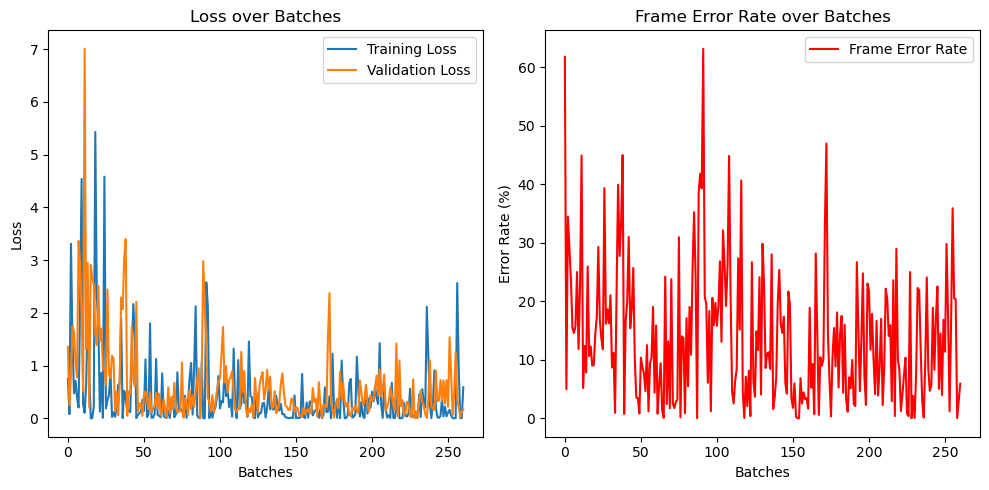

In [39]:
trainer = LinearProbeTrainer(model=classifier_model, train_loader=train_loader, test_loader=test_loader, device=device, lr=1e-5, plotting=True, batches_per_eval=1, desired_total_batches=1e3, patience=15)
trainer.train()

## Analyze

In [7]:
from linear_probe import ModelEvaluator

evaluator = ModelEvaluator(classifier_model, test_loader)
class_frame_error_rates, total_frame_error_rate = evaluator.validate_model_multiple_passes(num_passes=1, max_batches=1250)
evaluator.save_results(class_frame_error_rates, total_frame_error_rate, '/home/george-vengrovski/Documents/projects/tweety_bert_paper/results/test')

Evaluating: 100%|██████████| 25/25 [00:01<00:00, 18.31batch/s]


## Visualize Song and Not Song

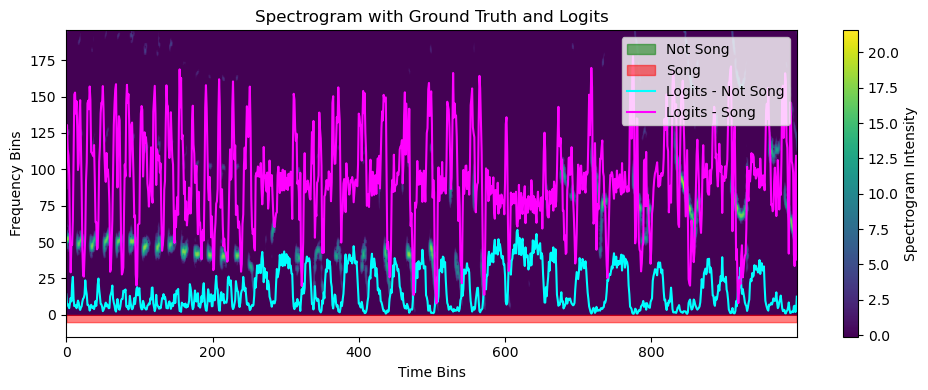

In [73]:
import matplotlib.pyplot as plt
import numpy as np
import torch

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def plot_spectrogram_with_labels_and_logits(spec, ground_truth_label, logits):
    # Apply sigmoid to logits to scale them between 0 and 1
    logits_sigmoid = sigmoid(logits.numpy())

    # Scale logits to match the frequency axis of the spectrogram
    freq_range = spec.shape[0]  # Assuming the frequency range is the first dimension of spec
    logits_scaled = logits_sigmoid * freq_range  # Scale the logits to the spectrogram's frequency range

    # Plotting
    plt.figure(figsize=(10, 4))

    # Plot spectrogram
    plt.imshow(spec.numpy(), aspect='auto', origin='lower')

    # Overlay ground truth labels as a bar
    song_bar = ground_truth_label.numpy()[:, 0]  # Assuming first column is for 'song'
    not_song_bar = ground_truth_label.numpy()[:, 1]  # Assuming second column is for 'not song'
    plt.fill_between(range(spec.shape[1]), -5, 0, where=song_bar > 0.5, color='green', step='mid', alpha=0.5, label='Not Song')
    plt.fill_between(range(spec.shape[1]), -5, 0, where=not_song_bar > 0.5, color='red', step='mid', alpha=0.5, label='Song')

    # Overlay logits as line plots
    # Note: We add a small offset to avoid plotting directly on the bottom axis
    plt.plot(logits_scaled[:, 0], color='cyan', label='Logits - Not Song')
    plt.plot(logits_scaled[:, 1], color='magenta', label='Logits - Song')

    plt.colorbar(label='Spectrogram Intensity')
    plt.xlabel('Time Bins')
    plt.ylabel('Frequency Bins')
    plt.title('Spectrogram with Ground Truth and Logits')
    plt.legend(loc='upper right')

    plt.tight_layout()
    plt.show()


spec, ground_truth_label, _ = next(iter(test_loader))


logits = classifier_model.forward(spec.to(device))

# first batch 
spec = spec[0]
ground_truth_label = ground_truth_label[0]
logits = logits[0]

# remove channel dims
spec = spec[0]
# Example usage with your data (convert tensors to CPU if on a different device)
plot_spectrogram_with_labels_and_logits(spec.detach().cpu(), ground_truth_label.detach().cpu(), logits.detach().cpu())
